# Environment setup

This section defines the libraries and utility functions,
and prepares and partitions the dataset.

In [72]:
# Libraries and utils
!pip3 install numpy pandas matplotlib sklearn xgboost eli5 interpret shap lime pygam scipy interpret_text
from itertools import chain
from math import pi
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
import interpret
import shap
import lime
import xgboost
import scipy
import eli5
import pygam
from IPython.display import display, HTML

import warnings
warnings.filterwarnings("ignore")

def print_table(lists, columns):
  display(pd.DataFrame(lists, columns=columns))

def hash_color_biased(string, light = 0, var = 0x7F):
  rand = random.Random(hash(string))
  r = rand.randint(light, light + var)
  g = rand.randint(light, light + var)
  b = rand.randint(light, light + var)
  return (r / 255.0, g / 255.0, b / 255.0)

In [44]:
# Download dataset
!test ! -f HelocData.csv || rm HelocData.csv
!wget https://github.com/ajzhanghku/Stat3612/raw/master/HelocData.csv
full_data = pd.read_csv("HelocData.csv")
np.random.seed(3612202003)

def phase_partition(df, train_ratio):
  rows = np.arange(df.shape[0])
  np.random.shuffle(rows)
  max = int(rows.shape[0] * train_ratio)
  train = df.loc[rows < max, ]
  test = df.loc[rows >= max, ]
  return train, test

features = [f"x{i}" for i in range(1, 24)]
train, test = phase_partition(full_data, 0.8)

--2020-12-06 15:08:03--  https://github.com/ajzhanghku/Stat3612/raw/master/HelocData.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ajzhanghku/Stat3612/master/HelocData.csv [following]
--2020-12-06 15:08:04--  https://raw.githubusercontent.com/ajzhanghku/Stat3612/master/HelocData.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 678028 (662K) [text/plain]
Saving to: ‘HelocData.csv’

HelocData.csv       100%[===================>] 662.14K  --.-KB/s    in 0.03s   

2020-12-06 15:08:04 (18.9 MB/s) - ‘HelocData.csv’ saved [678028/678028]



# Data preprocessing
## Handling missing data

In HelocData, missing values are represented by one of $-7, -8, -9$.

Bar charts for the distribution of each error code are plotted for analysis.

In [45]:
def phase_missing_stats(df):
  _, (ax0, ax1) = plt.subplots(2, 1, figsize=(16, 16))
  for i, code in enumerate([-7, -8, -9]):
    ax0.bar(np.arange(1, 24) * 4 + i, np.sum(df == code, 0), width=1, color=hash_color_biased(code, 0x60), label=f"$c = {code}$")
  ax0.set_title("Occurrences of missing values $c$")
  ax0.set_xlabel("Feature")
  ax0.set_ylabel("Occurrences of $c$ in feature")
  ax0.set_xticks(np.arange(1, 24) * 4 + 1)
  ax0.set_xticklabels(df.columns)
  ax0.legend()

  plt.figure(figsize=(16,8))
  for i, code in enumerate([-7, -8, -9]):
    errors = np.sum(df == code, 1)
    bins = np.bincount(errors)
    ax1.bar(np.arange(len(bins)) * 4 + i, bins, width=1, color=hash_color_biased(code, 0x60), label=f"$c = {code}$")
  ax1.set_title("Number of missing values on the same row")
  ax1.set_xlabel("Number of missing values ($=c$)")
  ax1.set_ylabel("Number of rows with $x$ occurrences of $c$")
  ax1.set_xticks(np.arange(len(bins)) * 4 + 1)
  ax1.set_xticklabels(list(map(str, range(len(bins)))))
  ax1.legend()

  plt.show()

phase_missing_stats(train[train.columns[1:]])

<Figure size 1152x576 with 0 Axes>

### Handling missing data

### Handling $-7$
From the first bar chart, $-7$ only occurs in `x9` and `x15`.
`x9` and `x15` are the numbers of months
since the most recent delinquency/inquiry.

$-7$ implies that delinquency/inquiry never happened,
so they should be imputed with a reasonable value that maximizes feature effect,
such as the corresponding extrema in their columns.

This is achieved by adding the features `x9_7` and `x15_7`,
indicating that the `x9`/`x15` column contains a "never happened" model,
then imputing the missing cells with $-1$.

For $i \in \left\{ \text{x9}, \text{x15} \right\}$,
regression-based models can choose an appropriate coefficient $\beta_{i\_7}$
such that column $i$ contributes to the result
by $\beta_{i\_7}$ if it is a missing value,
or by $\beta_i x$ if it is not missing.

### Handling $-8$
$-8$ means "no valid trades".

In `x18`, `x19` and `x23`,
$-8$ is the placeholder of division-by-zero errors.
In other columns such as `x21`,
$-8$ implies lack of installment trades, etc.

Therefore, a similar technique as in handling $-7$ can be used
for each column with $-8$ data.
Note that such imputation is only performed on
columns with at least one $-7$/$-8$ value.
If they never occur on the training data,
nothing can be inferred about their effects on testing data,
and adding such a feature to the model contributes no positive effect
on the model accuracy.

### Handling $-9$
$-9$ means data are uninvestigated.

From the second bar chart, it appears that occurrences of $-9$ are clustered,
i.e. rows that have at least one $-9$ most likely have all cells $-9$.
We call these rows Completely Uninvestigated Data (CUD).

Let $X$ be the random variable for our prediction
for a CUD row (`Bad = 1`)
and $p$ be the proportion of `RiskFlag = Bad` among the CUD rows.
The prediction accuracy $\Pr(X = 1) p + \Pr(X = 0) (1-p)$
is maximized when $X$ is the constant $\mathbf 1_{\{p > 0.5\}}$.
Therefore, the dataset is partitioned into CUD and non-CUD,
where further investigation is only performed on the non-CUD subset.


## Splitting nominal data
`x10` and `x11` are semi-nominal.
Labels beyond the monotonic constraint ($[0, 7]$ and $[2, 8]$ respectively)
are imputed as $0$ and an indicator column is added for each such label.

## Fixing RiskFlag
RiskFlag is converted to a 0/1 column
where `0` implies `Good` and `1` implies `Bad`
(consistent with the monotonicity constraint on $\Pr(\text{Bad} = 1)$).

In [46]:
def phase_handle_missing(df):
  # Convert RiskFlag to a 1/0 column
  df["RiskFlag"] = np.where(df["RiskFlag"] == "Bad", 1, 0)

  # Count uninvestigated cells, filter if there is at least one uninvestigated cell
  uninvestigated = np.sum(df == -9, 1)
  cud = df[uninvestigated > 0].copy()
  df = df[uninvestigated == 0].copy()
  cud_pred = round(np.average(cud["RiskFlag"]))

  # Detect presence of -7/-8 and add columns
  for col in df.columns[1:]:
    if col == "x10" or col == "x11":
      lower_bound, upper_bound = (0, 8) if col == "x10" else (2, 9)
      choices = df[col].unique()
      for choice in choices:
        if choice not in range(lower_bound, upper_bound):
          df[f"{col}_{choice}"] = np.where(df[col] == choice, 1, 0)
          df[col] = df[col].replace(choice, -1)
    else:
      for miss in [-7, -8]:
        count = np.sum(df[col] == miss)
        if count > 0:
          df[f"{col}_{-miss}"] = np.where(df[col] == miss, 1, 0)
          df[col] = df[col].replace(miss, -1)

  return cud_pred, df

def phase_merge_missing(train, test):
  c1 = train.columns
  c2 = test.columns
  for index, col in enumerate(c1):
    if col not in c2:
      print(f"No occurrences of {col} in test")
      test.insert(index, col, 0)
  for index, col in enumerate(c2):
    if col not in c1:
      print(f"No occurrences of {col} in train")
      train.insert(index, col, 0)

cud_pred, train = phase_handle_missing(train.copy())
cud_pred_test, test = phase_handle_missing(test.copy())
phase_merge_missing(train, test)
print(f"CUD prediction: {cud_pred}")
display(train)
display(test)

No occurrences of x10_9 in test
CUD prediction: 1.0


RiskFlag  x1   x2  x3   x4  x5  ...  x18_8  x19_8  x20_8  x21_8  x22_8  x23_8
0             1  75  169   2   59  21  ...      0      0      0      0      0      0
1             1  66  502   4  145  34  ...      0      0      0      0      0      0
2             0  69  338   2   62  22  ...      0      0      0      0      0      0
3             0  75  422   1   91  55  ...      0      0      0      0      0      0
4             1  63  242   2   68  25  ...      0      1      0      0      0      0
...         ...  ..  ...  ..  ...  ..  ...    ...    ...    ...    ...    ...    ...
10452         0  73  178   1   66   9  ...      0      0      0      0      0      0
10455         1  68   93  16   59  10  ...      0      0      0      0      0      0
10456         0  87  325   6  102  27  ...      0      0      0      0      0      0
10457         0  75  413   9  112  33  ...      0      0      0      0      0      0
10458         0  81  220   3   86  44  ...      0      1      0      0      0      0

[7881 rows x 36 columns]

RiskFlag  x1   x2  x3   x4  x5  ...  x18_8  x19_8  x20_8  x21_8  x22_8  x23_8
19            0  66  394   7  123  28  ...      0      1      0      1      0      0
23            0  71  410   4   53  19  ...      0      0      0      0      0      0
24            0  82  311  17  133  18  ...      0      1      0      0      0      0
28            1  73  105  12   14   3  ...      0      1      0      1      0      0
29            0  71   -1   2  102  16  ...      0      0      0      0      0      0
...         ...  ..  ...  ..  ...  ..  ...    ...    ...    ...    ...    ...    ...
10437         1  74  202   5   75  25  ...      0      1      0      0      0      0
10441         1  70  457   3  112  10  ...      0      0      0      0      0      0
10445         1  62  199   2   65  18  ...      0      0      0      0      0      0
10453         1  84  345  14   94  42  ...      0      0      0      0      0      0
10454         0  89  425  19  186  16  ...      0      1      0      1      0      0

[1980 rows x 36 columns]

In [47]:
train_x = train[train.columns[1:]].copy()
train_y = train["RiskFlag"].copy()
test_x = test[test.columns[1:]].copy()
test_y = test["RiskFlag"].copy()

In [48]:
# test_x = test_x[['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x2_8','x9_7','x9_8','x10_9','x15_7','x15_8','x18_8','x19_8','x20_8','x21_8','x22_8','x23_8']]

# Data exploration

## Correlation and scatterplot
Observe the high correlation between `x6`/`x7`, `x10`/`x11`, `x16`/`x17`.

`x6`/`x7` and `x16`/`x17` demonstrate an almost-superset-subset relationship.
This is given by the definition (e.g. "exclude last 7 days"),
as also observed from the triangular shape of their scatterplots.

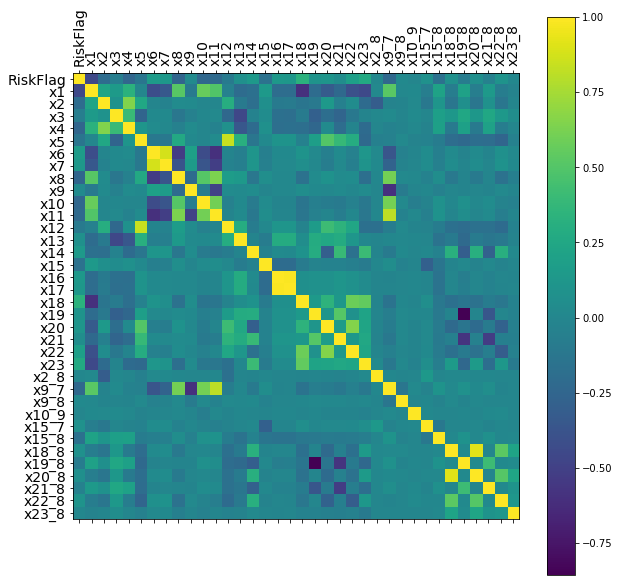

In [49]:
def phase_corrmat():
  f = plt.figure(figsize=(10,10))
  # df = train[features + ["RiskFlag"]]
  df = train
  plt.matshow(df.corr(), fignum=f.number)
  plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
  plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
  plt.colorbar()
phase_corrmat()

In [50]:
pd.plotting.scatter_matrix(train_x, figsize=(20,20), c=train_y.map({0: "g", 1: "r"}))
plt.show()

## Boxplot
From the boxplot,
it is apparent that `x1` has strong effect on `RiskFlag`.
This is especially clear in the scatterplot,
where along the row of `x1`, higher values of `x1` lead to a "Good" RiskFlag.

A similar observation is also given by some other values such as `x23`,
but their effects are notably weaker.

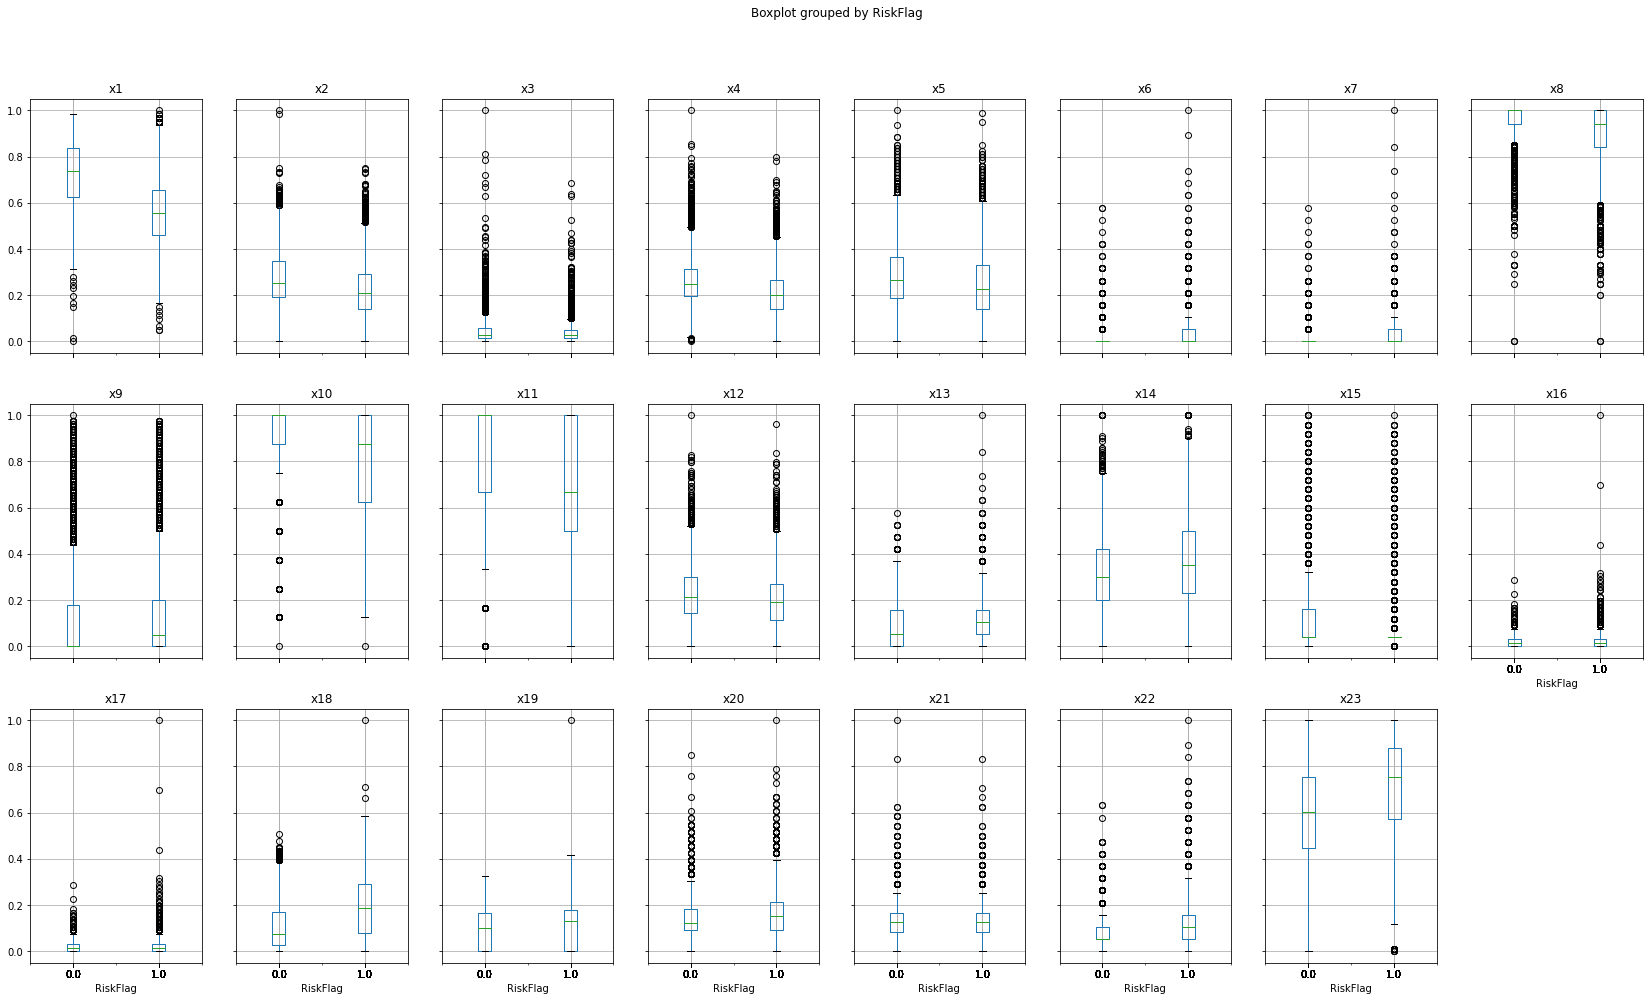

In [51]:
def phase_boxplot():
  from sklearn.preprocessing import MinMaxScaler
  scaled = pd.DataFrame(MinMaxScaler().fit_transform(train), columns=train.columns)
  scaled.boxplot(column=features, by="RiskFlag", layout=(3,8), figsize=(28,16))
  plt.show()
phase_boxplot()

# Feature selection
We perform backward selection to remove useless features.
Among all models we preliminarily tested,
XGBoost appeared to have the highest performance,
Along with its flexibility in handling feature relations,
we use a preliminary XGBoost model as a benchmark for feature selection.

Compared to other interpretation methods,
Variable Importance (VI) via Permutation Importance
is the most straightforward metric for whether a variable can be removed.
First we compute the VI of all features in the XGBoost model.

> **Note**: Due to the random nature of permutation,
running the following functions would give different results every time.
It is neither practical nor meaningful to set a specific seed for these tests.
The summary below will be based on our *original* execution.
We believe that this does not harm the reliability of our selection
because we selected our eventual feature subset
based on human interpretation.

In [52]:
def phase_feature_selection_direct_vi():
  xgb = xgboost.XGBClassifier()
  xgb.fit(train_x, train_y)

  perm = eli5.sklearn.PermutationImportance(xgb).fit(test_x, test_y)
  display(eli5.show_weights(perm, feature_names=list(train_x.columns)))

phase_feature_selection_direct_vi()

## Stepwise selection
We further analyze the feature importances using stepwise selection methods.
We iteratively remove one feature from the set of features,
retrain the model with the remaining features and select one to remove again.
We attempted two approaches:



### Most important first
In every step, we remove the most important feature
and add the removed feature to the final selection.
This preserves the features most important in the original model.

In [53]:
def phase_feature_selection_most_important_first():
  multiline = {column: [] for column in train_x.columns}

  threshold = 2

  def evaluate(subset):
    cv_folds = 5
    accuracies = []
    aucs = []
    importances = [0 for _ in subset]
    for i in range(cv_folds):
      start = round(i * train_y.shape[0] / cv_folds)
      end = round((i+1) * train_y.shape[0] / cv_folds)
      x = pd.concat((train_x[subset][:start], train_x[subset][end:]), axis=0)
      y = np.concatenate((train_y[:start], train_y[end:]), axis=0)
      xgb = xgboost.XGBClassifier()
      xgb.fit(x, y)
            
      pred_y = xgb.predict(train_x[subset][start:end])
      real_y = train_y[start:end]
      
      accuracy = sklearn.metrics.accuracy_score(real_y, pred_y)

      auc = sklearn.metrics.roc_auc_score(real_y, pred_y)
      print(f"  Fold {i}: accuracy {accuracy}, auc {auc}")
      
      accuracies.append(accuracy)
      aucs.append(auc)
            
      perm = eli5.sklearn.PermutationImportance(xgb).fit(train_x[subset][start:end], train_y[start:end])
      for i, imp in enumerate(perm.feature_importances_):
        importances[i] += imp
                
    auc = sum(aucs) / cv_folds
    importances = [imp / cv_folds for imp in importances]
        
    return (accuracy, auc, importances)
    
  subset = train_x.columns
  selected = []
  accuracy, auc, importances = evaluate(subset)
  print(f"Full model accuracy/auc: {accuracy}/{auc}")
  print(f"Full model importances: {importances}")
  accuracies = [accuracy]
  aucs = [auc]
  for column, imp in zip(subset, importances):
    multiline[column].append(imp)
  while len(subset) > threshold:
    imp_ord = np.flip(np.argsort(importances))
    print(f"Removing {subset[imp_ord[0]]}")
    selected.append(subset[imp_ord[0]])
    subset = [subset[i] for i in imp_ord[1:]]
    print("Remaining features: {}".format(", ".join(subset)))
        
    new_accuracy, new_auc, new_importances = evaluate(subset)
    print("New accuracy: {}".format(new_accuracy))
        
    accuracy = new_accuracy
    accuracies.append(accuracy)
    auc = new_auc
    aucs.append(auc)
        
    importances = new_importances
    for column, imp in zip(subset, importances):
      multiline[column].append(imp)
        
  _, (perf_ax, imp_ax, sp_ax) = plt.subplots(1, 3, figsize=(30, 10))
  
  perf_ax.set_title("Removal Performance")
  perf_ax.set_xlabel("Number of features removed")
  perf_ax.plot(range(len(accuracies)), accuracies, label="accuracy")
  perf_ax.plot(range(len(aucs)), aucs, label="AUC")
  perf_ax.legend()

  imp_ax.set_title("Feature importance")
  imp_ax.set_xlabel("Number of features removed")
  imp_ax.set_ylabel("Importance")
  for feature, imps in multiline.items():
    imp_ax.plot(range(len(imps)), imps, label=feature)
  imp_ax.legend() 

  sp_accuracies = []
  sp_aucs = []
  for j in range(1, len(selected) + 1):
    accuracy, auc, importances = evaluate(selected[0:j])
    sp_accuracies.append(accuracy)
    sp_aucs.append(auc)
  sp_ax.set_title("Selection Performance")
  sp_ax.set_xlabel("Number of features selected")
  sp_ax.plot(range(1, len(sp_accuracies) + 1), sp_accuracies, label="accuracy")
  sp_ax.plot(range(1, len(sp_aucs) + 1), sp_aucs, label="AUC")
  sp_ax.legend()
        
phase_feature_selection_most_important_first()

  Fold 0: accuracy 0.7373096446700508, auc 0.7364094404667197
  Fold 1: accuracy 0.7354060913705583, auc 0.734871461175815
  Fold 2: accuracy 0.7362079898541535, auc 0.7331801241834502
  Fold 3: accuracy 0.7284263959390863, auc 0.7269902034421212
  Fold 4: accuracy 0.7366751269035533, auc 0.7360134189850561
Full model accuracy/auc: 0.7366751269035533/0.7334929296506325
Full model importances: [0.07542178331278629, 0.0008121666468170339, 0.0018523895206795649, 0.006953880174719715, 0.007309354972655791, 0.00022836201874020467, -0.00012704840199698536, 0.010151511737572795, 0.0007611959996008544, 0.0022840064505953257, -0.00010152284263959643, 0.0013447592131818854, 0.0009643221563786497, 0.003578454882849602, 0.011724649063794595, -0.0002793648545558103, -0.00017758450312066907, 0.012663011114723394, 0.0010149387290009672, 0.0012180166028795902, 0.0009391345773154168, 0.001928290238163446, 0.0009898477157360562, 0.0, 0.0, -0.0001268230818008798, 0.0, 5.082579851868551e-05, 0.00850118614

### Least important first
In every step, we remove the least important feature.
The features last removed are used as the final selection.

This method is expected to remove collinearity.
Suppose $x_i$ and $x_j$ are highly correlated,
and $x_i$ has higher importance than $x_j$.
When $x_j$ is removed, the retrained model must rely on $x_i$
for the information previously provided by $x_j$,
so it is expected that $x_i$ takes the importances of both itself and $x_j$
as in the previous model.

In [54]:
def phase_feature_selection_least_important_first():
  multiline = {column: [] for column in train_x.columns}

  def evaluate(subset):
    cv_folds = 4
    accuracies = []
    aucs = []
    importances = [0 for _ in subset]
    for i in range(cv_folds):
      start = round(i * train_y.shape[0] / cv_folds)
      end = round((i+1) * train_y.shape[0] / cv_folds)
      x = pd.concat((train_x[subset][:start], train_x[subset][end:]), axis=0)
      y = np.concatenate((train_y[:start], train_y[end:]), axis=0)
      xgb = xgboost.XGBClassifier()
      xgb.fit(x, y)
            
      pred_y = xgb.predict(train_x[subset][start:end])
      real_y = train_y[start:end]
      
      accuracy = sklearn.metrics.accuracy_score(real_y, pred_y)

      auc = sklearn.metrics.roc_auc_score(real_y, pred_y)
      print(f"  Fold {i}: accuracy {accuracy}, auc {auc}")
      
      accuracies.append(accuracy)
      aucs.append(auc)
            
      perm = eli5.sklearn.PermutationImportance(xgb).fit(train_x[subset][start:end], train_y[start:end])
      for i, imp in enumerate(perm.feature_importances_):
        importances[i] += imp
                
    auc = sum(aucs) / cv_folds
    importances = [imp / cv_folds for imp in importances]
        
    return (accuracy, auc, importances)
    
  subset = train_x.columns
  accuracy, auc, importances = evaluate(subset)
  print(f"Full model accuracy/auc: {accuracy}/{auc}")
  print(f"Full model importances: {importances}")
  accuracies = [accuracy]
  aucs = [auc]
  for column, imp in zip(subset, importances):
    multiline[column].append(imp)
  while len(subset) > 2:
    imp_ord = np.argsort(importances)
    print(f"Removing {subset[imp_ord[0]]}")
    subset = [subset[i] for i in imp_ord[1:]]
    print("Remaining features: {}".format(", ".join(subset)))
        
    new_accuracy, new_auc, new_importances = evaluate(subset)
    print("New accuracy: {}".format(new_accuracy))
        
    accuracy = new_accuracy
    accuracies.append(accuracy)
    auc = new_auc
    aucs.append(auc)
        
    importances = new_importances
    for column, imp in zip(subset, importances):
      multiline[column].append(imp)
        
  _, (perf_ax, imp_ax) = plt.subplots(1, 2, figsize=(20,15))
  
  perf_ax.set_title("Removed performance")
  perf_ax.set_xlabel("Number of features removed")
  perf_ax.plot(range(len(accuracies)), accuracies, label="accuracy")
  perf_ax.plot(range(len(aucs)), aucs, label="AUC")
  perf_ax.legend()

  imp_ax.set_title("Feature importance")
  imp_ax.set_xlabel("Number of features removed")
  imp_ax.set_ylabel("Importance")
  for feature, imps in multiline.items():
    imp_ax.plot(range(len(imps)), imps, label=feature)
  imp_ax.legend()

phase_feature_selection_least_important_first()

  Fold 0: accuracy 0.7390862944162436, auc 0.7380846104250359
  Fold 1: accuracy 0.7299492385786802, auc 0.7280915098694708
  Fold 2: accuracy 0.7234906139015728, auc 0.7216434121653015
  Fold 3: accuracy 0.7385786802030457, auc 0.7378121849225633
Full model accuracy/auc: 0.7385786802030457/0.7314079293455928
Full model importances: [0.07164110567698634, 0.0008122342494083002, 0.00025367833587012226, 0.008603133764457743, 0.0070299932781679505, 0.00015228426395940686, 5.072279010113201e-05, 0.007131310087641368, -0.0011928290156507982, 0.002055631530285595, -0.00015237440346959062, 7.632241100011814e-05, 0.0005328661531289914, 0.0006858071478056339, 0.011952730840847098, 0.00015225850981361863, 0.0003807235369713724, 0.011648368346094513, 0.0015228426395939132, 0.002436123279944996, 0.0003045298967001398, 0.0023092712349370437, 0.0006601302644693218, 0.0, 0.0, 0.0002792135714046629, 0.0, 0.0, 0.005812041093315007, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Removing x9
Remaining features: x11, x23_8

## Summary
From the plots above,
it is observed that model performance is maximized
when only 15 features are removed.
Therefore, we select the best 15 features from each model
and review them with human interpretation,
as shown in the following table:

| Variable | Description | Random shuffling | Most Important First | Least Important First |
| :---: | :---: | :---: | :---: | :---: |
| x1 | Consolidated version of risk markers | &check; | &check; | &check; |
| x4 |Average Months in File | &check; | &check; | &check; |
| x5 | Number Satisfactory Trades | &check; | &check; | &check; |
| x8 | Percent Trades Never Delinquent | &check; | &check; | &check; |
| x12 | Number of Total Trades (total number of credit accounts) | &check; | &check; | &check; |
| x15 | Months Since Most Recent Inq excl 7 days | &check; | &check; | &check; |
| x18 | Net Fraction Revolving Burden. This is revolving balance divided by credit limit | &check; | &check; | &check; |
| x20 | Number Revolving Trades with Balance | &check; | &check; | &check; |
| x2 | Months Since Oldest Trade Open | &check; | &check; |  |
| x10 | Max Delq/Public Records Last 12 Months. See tab "MaxDelq" for each category | | &check; | &check; |
| x14 | Percent Installment Trades | &check; | | &check; |
| x15_8 | No inquiries excl 7 days | &check; | | &check; |
| x21 | Number Installment Trades with Balance | &check; | | &check; |
| x22 | Number Bank/Natl Trades w high utilization ratio | | &check; | &check; |
| x23 | Percent Trades with Balance | | &check; | &check; |
| x3 | Months Since Most Recent Trade Open | &check; | | |
| x6 | Number Trades 60+ Ever | | &check; | |
| x7 | Number Trades 90+ Ever | | &check; | |
| x9 | Months Since Most Recent Delinquency | | &check; | |
| x9_7 | Condition not Met (e.g. No Inquiries, No Delinquencies) | | &check; | |
| x11 | Max Delinquency Ever. | | &check; | |
| x16 | Number of Inq Last 6 Months | &check; | | |
| x17 | Number of Inq Last 6 Months excl 7days. Excluding the last 7 days removes inquiries that are likely due to price comparision shopping. | | | &check; |
| x19 | Net Fraction Installment Burden. This is installment balance divided by original loan amount. | &check; | | |

The following features are dropped:

- `x3`: Carrying account does not necessarily reflect one’s affordability. For example, the individual could be very rich and able to afford debts.
- `x6`: In method 3, it only ranks 21.
- `x7`: In method 3, it only ranks 34.
- `x9`: Comparing `x9 `with `x9_7`, the issue “having delinquency or not” should be more important since this reflect one’s ability in managing credit.
- `x9_7`: Cases `x9_7 `is included in variable “Max. Delq/Public Records Last 12 Months” (`x10`), which has been selected. 
- `x11`: In method 3, it is eliminated in the first 5 steps. Comparing to `x10`, it shows less significant. 
- `x16`, `x17`: Normally, credit card company will conduct due diligence to control risk before approving extra credit card application. For example, checking credit history. Therefore, people that successfully apply credit card usually is considered as “Good”. In this case, `x16 ` and `x17 `cannot contribute much to the prediction.
- `x19`: When comparing with `x18`, it is less significant. 

Therefore, only the following features are selected:

In [55]:
features = ["x1","x2","x4","x5","x8","x10","x12","x14","x15","x15_8","x18","x20","x21","x22","x23"]

In [56]:
# Now we redefine the training variables with this subset of features
train_x = train[features]
train_y = train["RiskFlag"]
test_x = test[features]
test_y = test["RiskFlag"]

Note that a number of indicator columns have been removed
while their corresponding features are still present.
This implies one of two possibilities:

- Imputation with $0$ is close enough to the optimal value
- There are too few data with the error term
for imputation value to matter

To verify this, we try to replace
the instances of $-1$ in each feature with their maximum value
and evaluate the change in accuracy w.r.t. XGBoost.

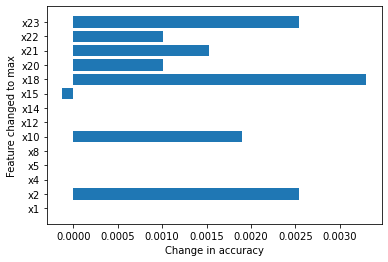

In [57]:
def phase_impute_max():
  def evaluate(tnx, tny, features):
    from sklearn.metrics import accuracy_score

    for feature in features:
      max = np.max(tnx[feature])
      tnx[feature] = tnx[feature].replace(-1, max)
    model = xgboost.XGBClassifier().fit(tnx, tny)
    return accuracy_score(tny, model.predict(tnx))

  base = evaluate(train_x.copy(), train_y, [])
  
  x = []
  y = []
  for feature in train_x.columns:
    if '_' in feature: continue
    accuracy = evaluate(train_x.copy(), train_y, [feature])
    x.append(feature)
    y.append(accuracy - base)

  xx = np.arange(len(x))
  plt.barh(xx, y)
  plt.xlabel("Change in accuracy")
  plt.ylabel("Feature changed to max")
  plt.yticks(xx, x)

phase_impute_max()

The feature with greatest improvement in accuracy
is `x18` with only $0.3\%$.
We consider this to be insignificant
and continue to use the model with only zero impute.

# Model construction
We have preliminarily tested a number of models and observed that
logistic GAM and XGBoost have the highest initial test accuracy
for white box and black box models respectively.

## White-box model (GAM)
We evaluated GAM models with splines terms of degrees 1 to 3
with grid search to tune hyperparameters.


### Without monotonic constraints

In [76]:
def make_pygam_terms(df, term_f):
  terms = None
  for feature in features:
    term = term_f(list(df.columns).index(feature))
    terms = (terms + term) if terms is not None else term
  return terms

def test_logit_gam(spline, terms):
  from sklearn.metrics import accuracy_score

  gam = pygam.LogisticGAM(terms, spline_order=spline)
  gam = gam.gridsearch(train_x.values, train_y.values, progress=False)
  
  print("spline={} Train Accuracy: {}".format(spline, accuracy_score(train_y, gam.predict(train_x))))
  print("spline={} Test Accuracy: {}".format(spline, accuracy_score(test_y, gam.predict(test_x))))
  return gam

gam1 = test_logit_gam(spline=1, terms=make_pygam_terms(train_x, pygam.s))
gam2 = test_logit_gam(spline=2, terms=make_pygam_terms(train_x, pygam.s))
gam3 = test_logit_gam(spline=3, terms=make_pygam_terms(train_x, pygam.s))

spline=1 Train Accuracy: 0.7397538383453877
spline=1 Test Accuracy: 0.7545454545454545
spline=2 Train Accuracy: 0.7391194010912321
spline=2 Test Accuracy: 0.7550505050505051
spline=3 Train Accuracy: 0.7397538383453877
spline=3 Test Accuracy: 0.7540404040404041


We observe that logistic GAM with degree-2 splines
has the highest accuracy.


#### Global Interpretation: Partial Dependence Plot 
We further consider its partial dependence plot

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     32.6604
Link Function:                        LogitLink Log Likelihood:                                 -4232.6261
Number of Samples:                         7881 AIC:                                             8530.5729
                                                AICc:                                            8530.8703
                                                UBRE:                                               3.0857
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2239
Feature Function                  Lam

None

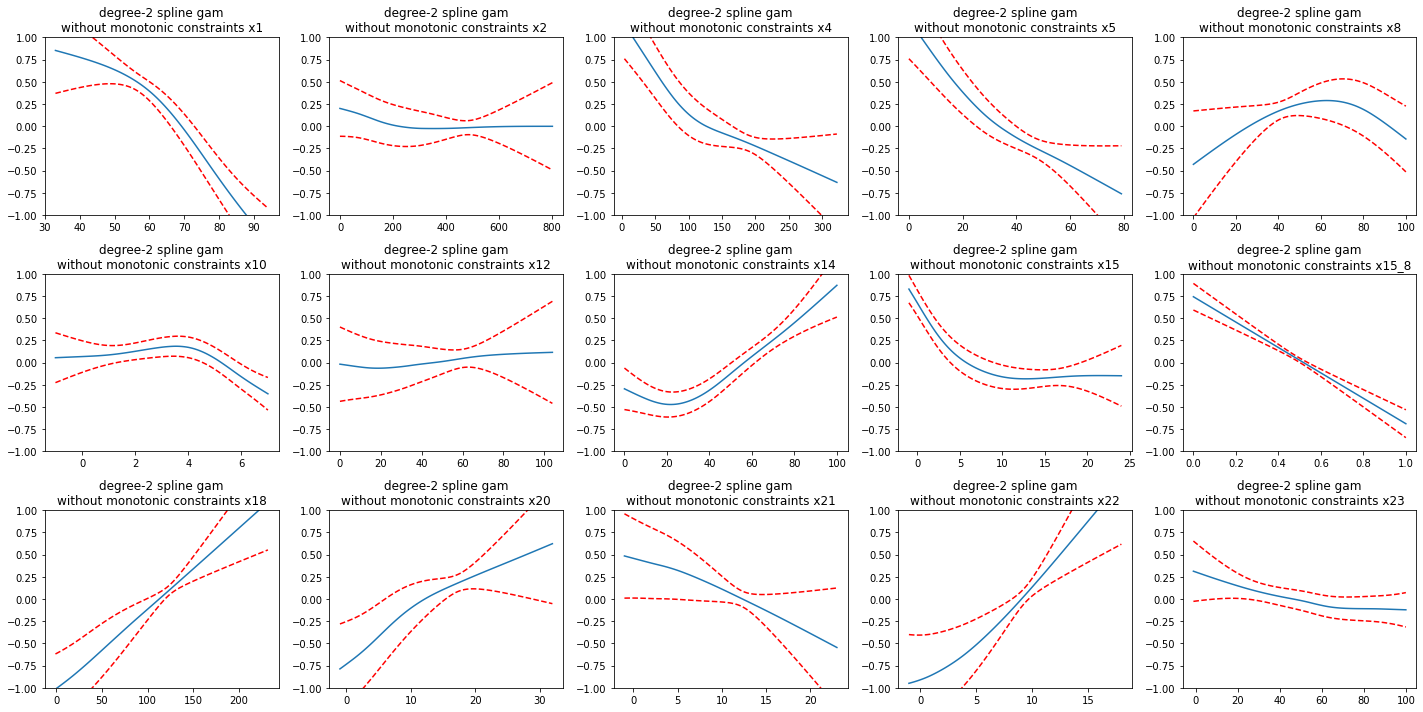

In [79]:
def pdp_plot(gam, title):
  fig, axs = plt.subplots(3,5,figsize=(20,10))
  for i, ax in enumerate(axs.flatten()):
    XX = gam.generate_X_grid(term=i)
    plt.subplot(ax)
    plt.ylim([-1,1])
    plt.plot(XX[:,i], gam.partial_dependence(term=i, X=XX))
    plt.plot(XX[:,i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    plt.title(title + " " + features[i])
  plt.tight_layout()
  plt.show()

display(gam2.summary())
pdp_plot(gam2, "degree-2 spline gam\nwithout monotonic constraints")

### With monotonicity constraints
For the sake of interpretability,
we also train models with monotonic constraints.

In [60]:
"""Constraints directly taken from HelocDataDict2.xlsx"""
monotonic_constraints = {
  "x1": -1,
  "x2": -1,
  "x3": -1,
  "x4": -1,
  "x5": -1,
  "x6": 1,
  "x7": 1,
  "x8": -1,
  "x9": -1,
  "x10": -1,
  "x11": -1,
  "x13": 1,
  "x15": -1,
  "x16": 1,
  "x17": 1,
  "x18": 1,
  "x19": 1,
  "x22": 1,
}

"""Returns a constrained term used in pygam models"""
def make_pygam_monotonic_terms(df):
  terms = None
  for feature in features:
    mono = monotonic_constraints.get(feature, 0)
    if mono > 0:
      term = pygam.s(list(df.columns).index(feature), constraints="monotonic_inc", n_splines=8)
    elif mono < 0:
      term = pygam.s(list(df.columns).index(feature), constraints="monotonic_dec", n_splines=8)
    else:
      term = pygam.s(list(df.columns).index(feature), n_splines=4)
    terms = (terms + term) if terms is not None else term
  return terms

mono_gam1 = test_logit_gam(spline=1, terms=make_pygam_monotonic_terms(train_x))
mono_gam2 = test_logit_gam(spline=2, terms=make_pygam_monotonic_terms(train_x))
mono_gam3 = test_logit_gam(spline=3, terms=make_pygam_monotonic_terms(train_x))

spline=1 Train Accuracy: 0.7377236391320898
spline=1 Test Accuracy: 0.7555555555555555
spline=2 Train Accuracy: 0.7387387387387387
spline=2 Test Accuracy: 0.7560606060606061
spline=3 Train Accuracy: 0.7400076132470499
spline=3 Test Accuracy: 0.7575757575757576


We observe that logistic GAM with degree-3 splines
has the highest accuracy.

The logistic GAM with degree-2 splines also has a higher accuracy
than the same model without monotonic constraint.

#### Global Interpretation: Partial Depedence Plot
And the corresponding PDP as shown below:

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     31.0162
Link Function:                        LogitLink Log Likelihood:                                 -4232.1011
Number of Samples:                         7881 AIC:                                             8526.2347
                                                AICc:                                            8526.5041
                                                UBRE:                                                3.085
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2239
Feature Function                  Lam

None

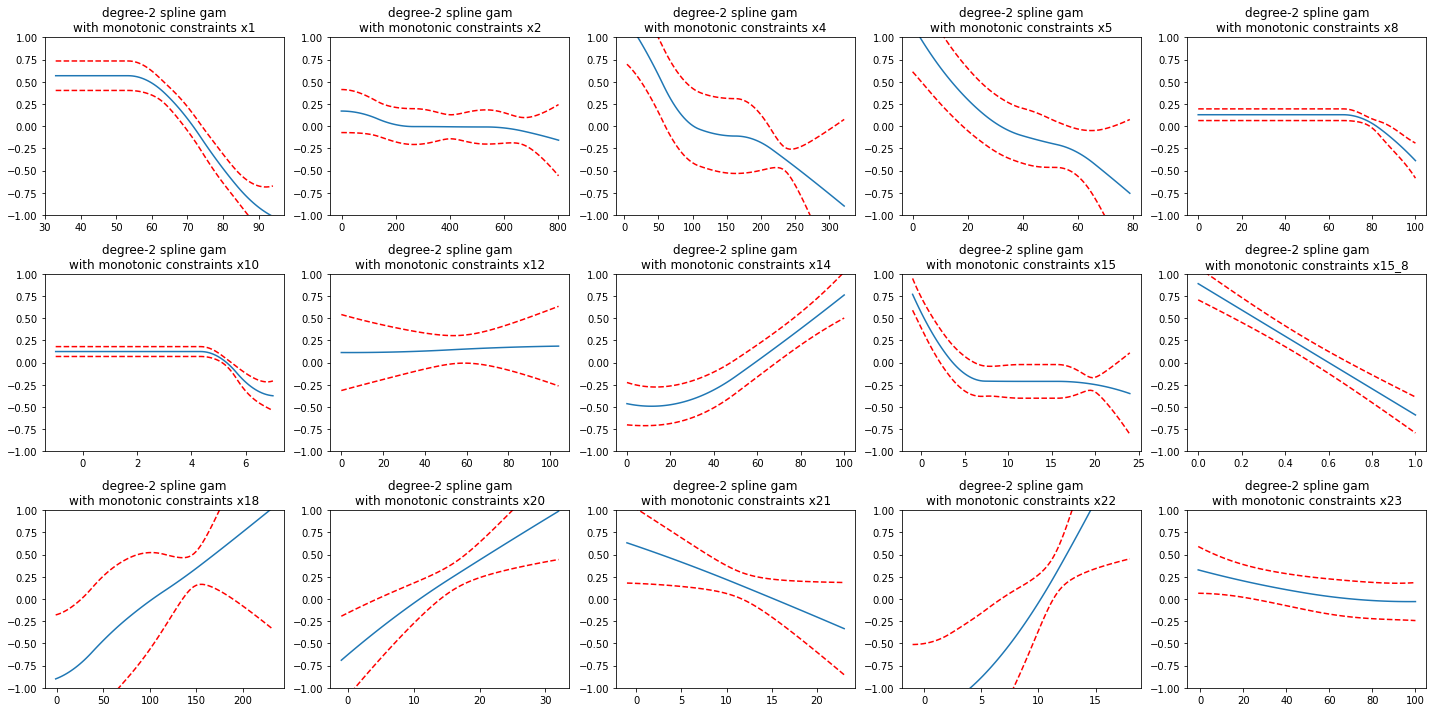

In [78]:
display(mono_gam2.summary())
pdp_plot(mono_gam2, "degree-2 spline gam\nwith monotonic constraints")

## Black-box model (XGBoost)


### Without monotonicity constraints

In [62]:
"""Returns a constraint string compatible with xgboost models"""
def xgboost_monotonic_string(df):
  return "(" + ",".join(map(lambda col: str(monotonic_constraints.get(col, 0)), df.columns)) + ")"

def xgboost_without_monotonic():
  from scipy.stats import uniform
  from sklearn.model_selection import RandomizedSearchCV
  from sklearn.metrics import accuracy_score

  tuned_parameters = {'kernel': ['rbf'], 'gamma': uniform(loc=0,scale=0.001), 'C': uniform(loc=5,scale=10)}
  clf = RandomizedSearchCV(xgboost.XGBClassifier(), tuned_parameters, cv=5,n_iter=20, scoring='accuracy')
  clf.fit(train_x, train_y)

  print("Train accuracy: {}".format(accuracy_score(train_y, clf.predict(train_x))))
  print("Test accuracy: {}".format(accuracy_score(test_y, clf.predict(test_x))))

xgboost_without_monotonic()

Train accuracy: 0.7540921202893034
Test accuracy: 0.7439393939393939


#### Global interpretation: Permutaiton Importance

In [63]:
def phase_feature_selection_direct_vi():
  from scipy.stats import uniform 
  from sklearn.model_selection import RandomizedSearchCV
  tuned_parameters = {'kernel': ['rbf'], 'gamma': uniform(loc=0,scale=0.001), 'C': uniform(loc=5,scale=10)}
  clf = RandomizedSearchCV(xgboost.XGBClassifier(), tuned_parameters, cv=5,n_iter=20, scoring='accuracy')
  clf.fit(train_x, train_y)

  perm = eli5.sklearn.PermutationImportance(clf).fit(test_x, test_y)
  display(eli5.show_weights(perm, feature_names=list(train_x.columns)))

phase_feature_selection_direct_vi()

`x1`, `x15_8`, `x15` are the top three. 
`x14`, `x10`, `x21` are relatively insignificant. 

#### Local interpretation: SHAP values on XGBoost

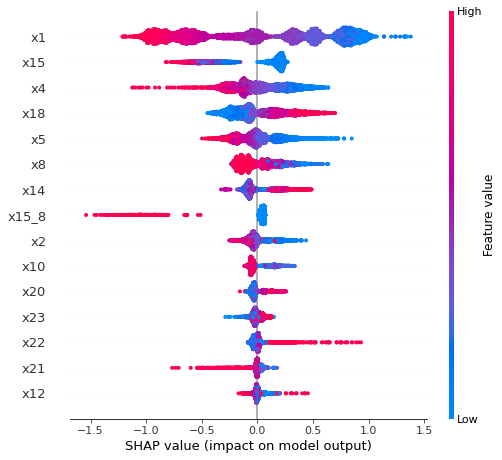

In [64]:
def shapSummary():
  import shap
  from sklearn.model_selection import RandomizedSearchCV
  from scipy.stats import uniform 
  tuned_parameters = {'kernel': ['rbf'], 'gamma': uniform(loc=0,scale=0.001), 'C': uniform(loc=5,scale=10)}
  clf = RandomizedSearchCV(xgboost.XGBClassifier(), tuned_parameters, cv=5,n_iter=20, scoring='accuracy', random_state=2019)

  clf.fit(train_x, train_y)
  model = clf.best_estimator_
  # define the explainer
  explainer = shap.TreeExplainer(model)
  # calculate the shape value on training data
  shap_values = explainer.shap_values(train_x)
  shap.initjs()
  # summary plot 1
  shap.summary_plot(shap_values, train_x,list(train_x.columns))
  # summary plot 2
  shap.summary_plot(shap_values, train_x, plot_type="bar",feature_names=list(train_x.columns))
shapSummary()

Similar with the permutation importance method, `x1`, `x15_8` are the top two. 

However, for the SHAP values, `x14` and `x10`'s importance raised. `x12`, `x21` are relatively insignificant. 

It is noted that the `15_8`'s importance drops significantly (from top 3 to 8)

#### Local Interpretation: LIME values on XGBoost


In [65]:
def limeXGBoost():
  from plotly.offline import init_notebook_mode, iplot
  init_notebook_mode(connected=True)
  import lime
  import lime.lime_tabular
  from scipy.stats import uniform
  from sklearn.model_selection import RandomizedSearchCV
  from sklearn.metrics import accuracy_score
  tuned_parameters = {'kernel': ['rbf'], 'gamma': uniform(loc=0,scale=0.001), 'C': uniform(loc=5,scale=10)}
  clf = RandomizedSearchCV(xgboost.XGBClassifier(), tuned_parameters, cv=5,n_iter=20, scoring='accuracy')
  clf.fit(train_x.values, train_y.ravel())
  explainer = lime.lime_tabular.LimeTabularExplainer(train_x.values, feature_names=list(train_x.columns), verbose=False, mode= "regression")
  exp = explainer.explain_instance(train_x.values[0], clf.predict, num_features=15)
  exp.show_in_notebook(show_table=True)
limeXGBoost()


Similar with permutation importance method, the `x15_8`, `x15` and `x1` are the top three importanace features among all. 

However, the `x15_8` and `x15` pair, expeciallly for `x15_8` raised signficantly which cannot be found in both permutation importance emthod and the SHAP interpretaiton method.

It may imply that LIME method counts the interaction affect and the collinearity more strongly.


- **Unlike the Permutation importance and SHAP**, LIME graph shows a more significant effect on `x15`, and our created feature on missing data `x15_8`

  → it may due to the collinearity between two

  → LIME may tend to count interaction




### With monotonicity constraints

In [66]:
def xgboost_with_monotonic():
  from scipy.stats import uniform
  from sklearn.model_selection import RandomizedSearchCV
  from sklearn.metrics import accuracy_score

  xgb = xgboost.XGBClassifier(monotone_constraints=xgboost_monotonic_string(train_x))
  tuned_parameters = {'kernel': ['rbf'], 'gamma': uniform(loc=0,scale=0.001), 'C': uniform(loc=5,scale=10)}
  clf = RandomizedSearchCV(xgb, tuned_parameters, cv=5,n_iter=20, scoring='accuracy', random_state=2019)
  clf.fit(train_x, train_y)

  print("Train accuracy: {}".format(accuracy_score(train_y, clf.predict(train_x))))
  print("Test accuracy: {}".format(accuracy_score(test_y, clf.predict(test_x))))
  display(clf)

xgboost_with_monotonic()

Train accuracy: 0.7495241720593834
Test accuracy: 0.7505050505050505


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None,
                                           monotone_constraints='(-1,-1,-1,-1,-1,-1,0,0,-1,0,1,0,0,1,0)',
                                           n_estimators=100, n_jobs=1,
                                           nthread=None,
                                           objectiv...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_iter

#### Global interpretation: Permutaiton Importance

In [67]:
def phase_feature_selection_direct_vi():
  from scipy.stats import uniform 
  from sklearn.model_selection import RandomizedSearchCV

  xgb = xgboost.XGBClassifier(monotone_constraints=xgboost_monotonic_string(train_x))
  tuned_parameters = {'kernel': ['rbf'], 'gamma': uniform(loc=0,scale=0.001), 'C': uniform(loc=5,scale=10)}
  clf = RandomizedSearchCV(xgb, tuned_parameters, cv=5,n_iter=20, scoring='accuracy', random_state=2019)
  clf.fit(train_x, train_y)

  perm = eli5.sklearn.PermutationImportance(clf).fit(test_x, test_y)
  display(eli5.show_weights(perm, feature_names=list(train_x.columns)))

phase_feature_selection_direct_vi()

Similar with the without monotonic one, `x1`, `x15` are the top two and`x10`, `x21` are relatively insignificant. 


However, with the monotonic constraint, `x4`and `x14`'s importance raised. Such result can be found in the SHAP values without monotonicity.



#### Local Interpretation: LIME values on XGBoost


In [68]:
def limeXGBoost():
  from plotly.offline import init_notebook_mode, iplot
  init_notebook_mode(connected=True)
  import lime
  import lime.lime_tabular
  from scipy.stats import uniform
  from sklearn.model_selection import RandomizedSearchCV
  from sklearn.metrics import accuracy_score

  xgb = xgboost.XGBClassifier(monotone_constraints=xgboost_monotonic_string(train_x))
  tuned_parameters = {'kernel': ['rbf'], 'gamma': uniform(loc=0,scale=0.001), 'C': uniform(loc=5,scale=10)}
  clf = RandomizedSearchCV(xgb, tuned_parameters, cv=5,n_iter=20, scoring='accuracy', random_state=2019)
  clf.fit(train_x.values, train_y.ravel())
  explainer = lime.lime_tabular.LimeTabularExplainer(train_x.values, feature_names=list(train_x.columns), verbose=False, mode= "regression")
  exp = explainer.explain_instance(train_x.values[0], clf.predict, num_features=15)
  exp.show_in_notebook(show_table=True)

limeXGBoost()


Similar with the LIME on the model without monotonic constraint, the `x15_8`, `x15` and `x1` are the top three with the highly ranked the `x15_8` and `x15`.




#### Local interpretation: SHAP values on XGBoost

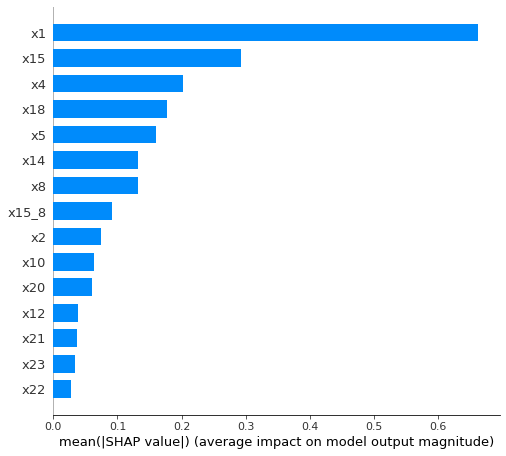

In [69]:
def shapSummary():
  import shap
  from scipy.stats import uniform 
  from sklearn.model_selection import RandomizedSearchCV
  xgb = xgboost.XGBClassifier(monotone_constraints=xgboost_monotonic_string(train_x))
  tuned_parameters = {'kernel': ['rbf'], 'gamma': uniform(loc=0,scale=0.001), 'C': uniform(loc=5,scale=10)}
  clf = RandomizedSearchCV(xgb, tuned_parameters, cv=5,n_iter=20, scoring='accuracy', random_state=2019)

  clf.fit(train_x, train_y)
  model = clf.best_estimator_
  # define the explainer
  explainer = shap.TreeExplainer(model)
  # calculate the shape value on training data
  shap_values = explainer.shap_values(train_x)
  shap.initjs()
  # summary plot 1
  shap.summary_plot(shap_values, train_x,list(train_x.columns))
  # summary plot 2
  shap.summary_plot(shap_values, train_x, plot_type="bar",feature_names=list(train_x.columns))
shapSummary()

## Force plot on XGBOOST with monotonic constraint


In [70]:
def force_plot():
  import shap
  from scipy.stats import uniform 
  from sklearn.model_selection import RandomizedSearchCV

  tuned_parameters = {'kernel': ['rbf'], 'gamma': uniform(loc=0,scale=0.001), 'C': uniform(loc=5,scale=10)}
  clf = RandomizedSearchCV(xgboost.XGBClassifier(), tuned_parameters, cv=5,n_iter=20, scoring='accuracy', random_state=2019)

  clf.fit(train_x, train_y)
  model = clf.best_estimator_
  # define the explainer
  explainer = shap.TreeExplainer(model)
  # calculate the shape value on training data
  shap_values = explainer.shap_values(train_x)
  shap.initjs()
  # force_plot for first 200 trainning samples
  shap.force_plot(explainer.expected_value, shap_values[:200], train_x[:200], feature_names=list(train_x.columns))
force_plot()

## Force plot on XGBOOST with monotonic constraint


In [71]:
def force_plot():
  import shap
  from scipy.stats import uniform 
  from sklearn.model_selection import RandomizedSearchCV
  xgb = xgboost.XGBClassifier(monotone_constraints=xgboost_monotonic_string(train_x))
  tuned_parameters = {'kernel': ['rbf'], 'gamma': uniform(loc=0,scale=0.001), 'C': uniform(loc=5,scale=10)}
  clf = RandomizedSearchCV(xgb, tuned_parameters, cv=5,n_iter=20, scoring='accuracy', random_state=2019)

  clf.fit(train_x, train_y)
  model = clf.best_estimator_
  # define the explainer
  explainer = shap.TreeExplainer(model)
  # calculate the shape value on training data
  shap_values = explainer.shap_values(train_x)
  shap.initjs()
  # force_plot for first 200 trainning samples
  shap.force_plot(explainer.expected_value, shap_values[:200], train_x[:200], feature_names=list(train_x.columns))
force_plot()

# Result

To compare the performance of white box and black box model, 
the following section we will present the 4 interpretation methods in both global and local approaches.

Based on the result found, we will have the comparison between the white-box and black box models.

### 1. Comparison between white box and black box on different interpretation methods

|           | White Box (Logistic GAM)| Black Box (XGBoost)|
|------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------|
| Monotonic Constraint Accuracy| The test accuracy of logistic GMA with monotonic constraints is **larger** than that without monotonic constraints| The test accuracy of XGBoost with monotonic constraints is **larger** than that without monotonic constraints|
| Monotonic Constraint reasoning| More straight sections are observed on the PDP plots, indicating that the White Box is less affected by local fluctuations of data and thus have **less overfitting**.|Unfitted expectation of the performance before and after with constraint are observed in Black Box, indicating that an **overfitting issue might exists**.|
| Individual Value: x1 (PDP VS LIME) | The Partial dependence plot of variable x1 shows a decreasing trend **from around 70 to 80**.                                                                              | A similar performance is observed in LIME, in which the effect of **72 $<$ x1 $\leq$ 80** is shown to be more significant.                                                                        |
| Individual Value: x8 (PDP VS LIME) | The Partial dependence plot of variable x8 shows a decreasing trend **from around 70 to 100**.                                                                             | A different performance is shown in LIME, in which 97-100 has a more significant effect, indicating that XGBoost is more flexible.                                               |

### 2. Final Model selections

2.1 Accuracy for models without monotonic constraint

| (without monotonic)   | Logistic GAM (RELU)     | XGBoost random serarch |
|-----------------------|--------------------------|------------------------|
| Accuracy on test data |  <font color='red'> 0.7555555555555555   &check; </font> | 0.7429292929           |

2.2 Accuracy for models with monotonic constraint

| (with monotonic)   | Logistic GAM (Spline 2)        | XGBoost random serarch |
|-----------------------|--------------------------|------------------------|
| Accuracy on test data | <font color='red'>  0.76010101010101  &check;  </font> | 0.750505050505           |

